[VAE](https://en.wikipedia.org/wiki/Variational_autoencoder)

[Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

___

## VAE = Encoder + Decoder

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.mu = nn.Linear(hidden2_dim, z_dim)
        self.std = nn.Linear(hidden2_dim, z_dim)

    def forward(self, x):
        hidden1 = torch.tanh(self.linear1(x))
        hidden2 = torch.tanh_(self.linear2(hidden1))
        z_mu = self.mu(hidden2)
        z_std = self.std(hidden2)

        return z_mu, z_std

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden1_dim, hidden2_dim, input_dim) -> None:
        super().__init__()
        self.linear1 = nn.Linear(z_dim, hidden1_dim)
        self.linear2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.out = nn.Linear(hidden2_dim, input_dim)

    def forward(self, z):
        hidden1 = torch.tanh(self.linear1(z))
        hidden2 = torch.tanh(self.linear2(hidden1))
        pred = self.out(hidden2)

        return pred

torch.randn_like(input, *, dtype=None, layout=None, device=None, requires_grad=False, memory_format=torch.preserve_format) 

Returns a tensor with the same size as input filled with random numbers from a normal **distribution with mean 0 and variance 1**

torch.randn_like(input) is equivalent to torch.randn(input.size(), dtype=input.dtype, layout=input.layout, device=input.device).

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, z_dim) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim, hidden1_dim, hidden2_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden1_dim, hidden2_dim, input_dim)

    def reparameterize(self, z_mu, z_std):
        if self.training:
            sd = torch.exp(z_std / 2)
            eps = torch.randn_like(sd)
            return eps.mul(sd).add_(z_mu)
        else:
            return z_mu

    def forward(self, x):
        z_mu, z_std = self.encoder(x)
        z_sample = self.reparameterize(z_mu, z_std)
        pred = self.decoder(z_sample)
        return pred, z_mu, z_std

___

## Loss Function

In [ ]:
def compute_loss(x, x_pred, mean, log_sd):
    RCL = F.mse_loss(x_pred, x, reduction='sum')
    KLD = -0.5*torch.sum(1+log_sd - mean.pow(2) - log_sd.exp())
    return RCL + KLD

___

In [ ]:
   ###### intializing data and model parameters
input_dim = 100
batch_size = 500    
hidden_dim1 = 64
hidden_dim2 = 32
z_dim = 20
samples = 100000

In [15]:
from GP1D_gen import GP1D
from torch.utils.data import Dataset, DataLoader

In [16]:
###### creating data, model and optimizer
train_ds = GP1D(dataPoints=input_dim, samples=samples, ls=0.1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [20]:
len(train_ds)

100000

In [22]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '10 different function realizations at fixed 100 points\nsampled from a Gaussian process with RBF')

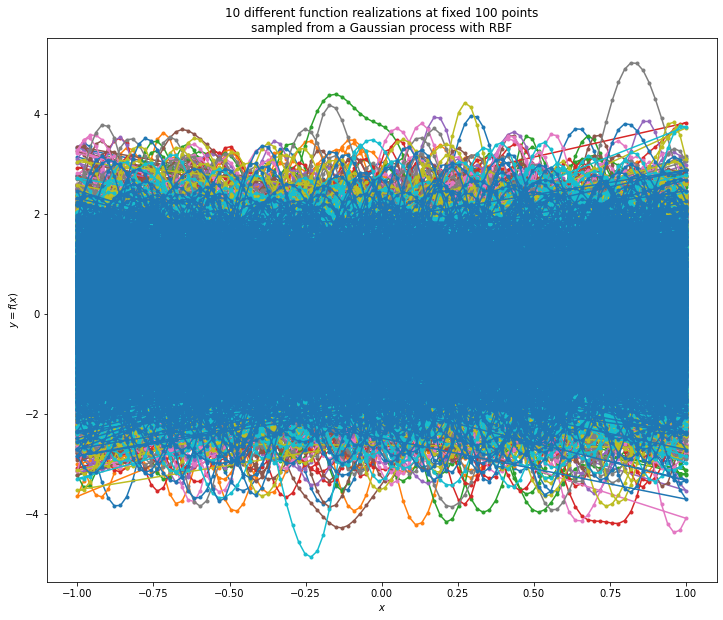

In [26]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
for no, dt in enumerate(train_dl):
        ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), marker='o', markersize=3)
        if no > 9: break
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('10 different function realizations at fixed 100 points\n'
    'sampled from a Gaussian process with RBF')

___

In [28]:
import torch.optim as optim 

In [29]:
model = VAE(input_dim, hidden_dim1, hidden_dim2, z_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)